In [5]:
# data manipulation
import pandas as pd
import numpy as np
import itertools

# explore
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# nlp
import unicodedata
import re
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk.sentiment
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes as nb

# local
import wrangle as w
import model as m

# Acquire

In [6]:
df = w.wrangle_complaints()

parquet file found and loaded


In [7]:
# from google.oauth2 import service_account
# import pandas_gbq

# credentials = service_account.Credentials.from_service_account_file(
#     'my-ds-projects-d864a770b51b.json',
# )
# df = pandas_gbq.read_gbq("select * from cfpb_complaints.complaint_database",dialect='standard',project_id="my-ds-projects",use_bqstorage_api=True,credentials=credentials)
# df

In [8]:
# df = w.check_file_exists_gbq('cfpb.csv','service_key.json')
# df.head(5)

In [9]:
# df.info()

# Prepare

In [10]:
# df_clean = w.clean_data(df.copy())
# df_clean.head()

In [11]:
# df_clean.info()

In [12]:
# pd.set_option('display.max_colwidth',None)

In [13]:
# df_clean_sample = prep_narrative(df_clean.head(10000))
# df_clean_sample[['narrative','clean','lemon']].head(1)

In [14]:
# all_words = [word for row in df_clean_sample['clean'] for word in row.split()]
# all_words = all_words.sort()

In [15]:
# type(all_words)

In [16]:
# all_words.sort()

In [17]:
# all_words

In [18]:
# sample_str = df_clean.narrative[0]
# sample_str

In [19]:
# sample_str_sub = re.sub(r'[X{1,}\d\']', ' ', string=sample_str)
# sample_str_sub

In [20]:
# sample_str_clean = basic_clean(sample_str_sub)
# sample_str_clean

In [21]:
# sample_str_token = token_it_up(sample_str_clean)
# sample_str_token

In [22]:
# sample_str_stop = remove_stopwords(sample_str_token,["&#9;", "12", "'"])
# sample_str_stop

In [23]:
# sample_str_lem = lemmad(sample_str_stop)
# sample_str_lem

In [24]:
# df_lem = w.prep_narrative(df_clean)
# df_lem.head(1)

In [25]:
# df_lem.to_parquet('df_lem.parquet')

In [26]:
# df_lem = pd.read_parquet('df_lem.parquet')
# df_lem.head(1)

In [27]:
# df_lem = pd.read_parquet('df_prep.parquet')
# df_lem.head(1)

In [28]:
# df_lem.company_response_to_consumer.value_counts(normalize=True).plot(
#     kind='barh',
#     title='Percent of Company Responses to Customer',
#     xlabel='Percent of Responses',
#     ylabel='Company Response');

In [29]:
# df_lem.company_response_to_consumer.value_counts(normalize=True)

In [30]:
# all_words = [word for row in df_lem['lemon'] for word in row.split()]
# all_words.sort()
# all_words

# Explore

In [31]:
df_prep = pd.read_parquet('cfpb_prep.parquet')

In [32]:
train, validate, test = w.split_data(df_prep,'company_response_to_consumer')

Prepared DF: (1246736, 8)
Train: (748041, 8)
Validate: (249347, 8)
Test: (249348, 8)


In [33]:
# train.head(1)

In [34]:
# train.company_response_to_consumer.value_counts(normalize=True)

In [35]:
# validate.company_response_to_consumer.value_counts(normalize=True)

In [36]:
# test.company_response_to_consumer.value_counts(normalize=True)

## 8.Which product is more likely to have monetary relief?

In [37]:
money = train[train.company_response_to_consumer=='Closed with monetary relief']
money.head(1)

,date_received,company_name,state,tags,company_response_to_consumer,product_bins,clean,lemon
944870,2015-05-12,"CITIBANK, N.A.",CA,Average Person,Closed with monetary relief,mortgage,it has been since that i first applied for the...,since first applied refinance today decision c...


In [38]:
money.product_bins.value_counts()

credit_card        12967
bank                9171
mortgage            2421
money_service       1961
loans               1811
credit_report       1196
debt_collection     1051
Name: product_bins, dtype: int64

In [39]:
money.product_bins.value_counts(normalize=True)

credit_card        0.424063
bank               0.299922
mortgage           0.079175
money_service      0.064131
loans              0.059226
credit_report      0.039113
debt_collection    0.034371
Name: product_bins, dtype: float64

In [40]:
cross = pd.crosstab(train['product_bins'],train['company_response_to_consumer'],normalize='index')
cross

company_response_to_consumer,Closed,Closed with explanation,Closed with monetary relief,Closed with non-monetary relief,Untimely response
product_bins,,,,,
bank,0.004523,0.745280,0.195648,0.053525,0.001024
credit_card,0.000999,0.693988,0.196205,0.107870,0.000938
credit_report,0.000161,0.754289,0.003111,0.241302,0.001137
debt_collection,0.010366,0.851144,0.008667,0.117403,0.012420
loans,0.003797,0.887540,0.036578,0.063420,0.008665
money_service,0.000267,0.832923,0.104844,0.059292,0.002673
mortgage,0.007433,0.913222,0.039550,0.037459,0.002336


In [41]:
cross['Closed with monetary relief'].sort_values()

product_bins
credit_report      0.003111
debt_collection    0.008667
loans              0.036578
mortgage           0.039550
money_service      0.104844
bank               0.195648
credit_card        0.196205
Name: Closed with monetary relief, dtype: float64

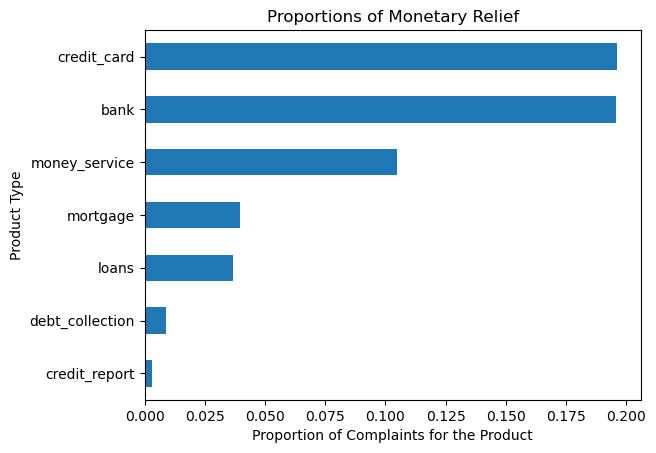

In [42]:
cross['Closed with monetary relief'].sort_values().plot(kind='barh', title='Proportions of Monetary Relief', xlabel='Proportion of Complaints for the Product', ylabel='Product Type');

In [43]:
# credit card and bank related products have the highest chance of getting monetary relief at just under 20%
# it makes sense that credit report products have the least chance of getting monetary relief

In [44]:
def monetary_product(train):
    # make crosstab of product and responses and normalize to get product proportions
    cross = pd.crosstab(train['product_bins'],train['company_response_to_consumer'],normalize='index')
    # plot monetary relief products
    cross['Closed with monetary relief'].sort_values(
        ).plot(kind='barh', 
                title='Proportions of Monetary Relief', 
                xlabel='Proportion of Complaints for the Product', 
                ylabel='Product Type',
                );

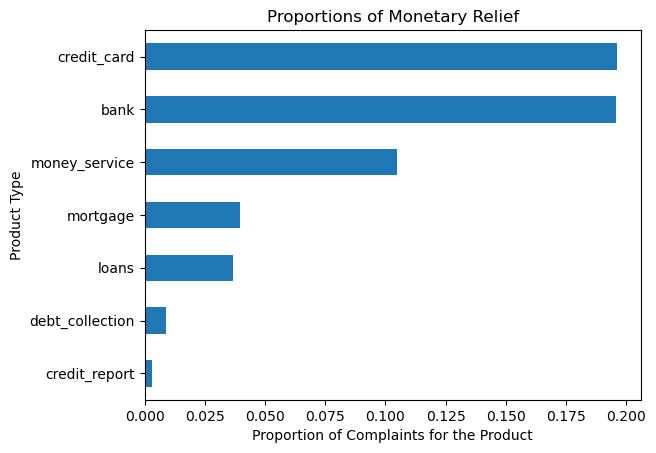

In [45]:
monetary_product(train)

## 9. Are there more complaints during certain seasons of the year?

In [46]:
# from datetime import datetime

In [47]:
# train.head(1)

In [48]:
# train['month'] = train.date_received.apply(lambda row: row.strftime("%m")).astype(str)
# train['year'] = train.date_received.apply(lambda row: row.strftime("%y")).astype(str)

In [49]:
# # Performed 1 aggregation grouped on columns: 'month', 'year'
# yearly = train.groupby(['month', 'year']).agg(year_count=('year', 'count'))

# # Performed 1 aggregation grouped on column: 'month'
# monthly = yearly.groupby(['month']).agg(year_count_mean=('year_count', 'mean'))

In [50]:
# train.groupby(['month']).agg(month_count=('month', 'count')).plot(kind='bar')

# Modeling

In [51]:
response_categories = [
    'Closed with explanation',
    'Closed with non-monetary relief',
    'Closed with monetary relief',
    'Untimely response',
    'Closed'
]

sm_train = []
sm_val = []
sm_test = []

small_train = pd.DataFrame()
small_val = pd.DataFrame()
small_test = pd.DataFrame()

random_state = 123
percent = .2

for category in response_categories:
    sm_train.append(int(round(len(train[train.company_response_to_consumer == category]) * percent, 0)))
    sm_val.append(int(round(len(validate[validate.company_response_to_consumer == category]) * percent, 0)))
    sm_test.append(int(round(len(test[test.company_response_to_consumer == category]) * percent, 0)))
    
    small_train = small_train.append(train[train.company_response_to_consumer == category].sample(sm_train[-1], random_state=random_state))
    small_val = small_val.append(validate[validate.company_response_to_consumer == category].sample(sm_val[-1], random_state=random_state))
    small_test = small_test.append(test[test.company_response_to_consumer == category].sample(sm_test[-1], random_state=random_state))

small_train.reset_index(drop=True, inplace=True)
small_val.reset_index(drop=True, inplace=True)
small_test.reset_index(drop=True, inplace=True)

In [52]:
small_train.shape

(149609, 8)

In [53]:
X_train = m.encode(small_train)
X_train = X_train.drop(columns=['date_received','company_response_to_consumer','clean','state','company_name','tags','product_bins'])
y_train = small_train['company_response_to_consumer']
X_val = m.encode(small_val)
X_val = X_val.drop(columns=['date_received','company_response_to_consumer','clean','state','company_name','tags','product_bins'])
y_val = small_val['company_response_to_consumer']
X_test = m.encode(small_test)
X_test = X_test.drop(columns=['date_received','company_response_to_consumer','clean','state','company_name','tags','product_bins'])
y_test = small_test['company_response_to_consumer']
X_train.head()

,lemon,Older American,"Older American, Servicemember",Servicemember,credit_card,credit_report,debt_collection,loans,money_service,mortgage
0,trying contact grain technology inc debt owed ...,0,0,0,0,0,1,0,0,0
1,bought large rug start vacation called filed d...,0,0,0,1,0,0,0,0,0
2,original complaint went car dealership ohio lo...,0,0,0,0,1,0,0,0,0
3,synopsis loan demand estate loan originated an...,0,0,0,0,0,0,0,0,1
4,may concern writing dispute fraudulent charge ...,0,0,0,0,1,0,0,0,0


In [60]:
def make_cv(Xtr,Xv,Xt):
    """
    The function `make_cv` takes in three sets of data (train, validation, and test) and converts them
    into bag-of-words representations using a CountVectorizer with n-gram range of 1 to 3, and then
    returns the transformed data as dataframes.
    
    :param Xtr: Xtr is the training data, which is a pandas DataFrame containing the lemmatized text
    data
    :param Xv: Xv is the validation dataset, which is used to evaluate the performance of the model
    during training. It is a subset of the overall dataset that is not used for training the model but
    is used to tune the hyperparameters and assess the model's generalization ability
    :param Xt: Xt is the test data, which is a dataframe containing the text data that you want to
    classify or analyze
    :return: three dataframes: Xtr_cv, Xv_cv, and Xt_cv.
    """
    #make my bag of words up to trigrams cv and keep single characters
    cv = CountVectorizer(token_pattern=r'(?u)\b\w+\b',lowercase=False, max_features=2900)
    # fit and transform train
    Xtr_bow_cv = cv.fit_transform(Xtr.lemon.astype(str))
    # transform val and test
    Xv_bow_cv = cv.transform(Xv.lemon.astype(str))
    Xt_bow_cv = cv.transform(Xt.lemon.astype(str))
    # make dfs
    Xtr_cv = pd.DataFrame(Xtr_bow_cv.todense(),columns=cv.get_feature_names_out(),index=Xtr.index)
    Xv_cv = pd.DataFrame(Xv_bow_cv.todense(),columns=cv.get_feature_names_out(),index=Xv.index)
    Xt_cv = pd.DataFrame(Xt_bow_cv.todense(),columns=cv.get_feature_names_out(),index=Xt.index)
    return Xtr_cv,Xv_cv,Xt_cv


def make_tfidf(Xtr,Xv,Xt):
    """
    The function `make_tfidf` takes in three sets of data (train, validation, and test) and applies the
    TF-IDF vectorization technique to convert the text data into numerical features, using n-grams up to
    trigrams and keeping single characters. It then returns the transformed data as pandas DataFrames.
    
    :param Xtr: Xtr is the training data, which is a dataframe containing the text data that you want to
    transform into TF-IDF features. The "lemmatized" column in the dataframe contains the preprocessed
    text data
    :param Xv: Xv is the validation dataset, which is used to evaluate the performance of the model
    during training
    :param Xt: Xt is the input data for the test set. It is a dataframe containing the text data that
    needs to be transformed into TF-IDF representation
    :return: three dataframes: Xtr_tfidf, Xv_tfidf, and Xt_tfidf.
    """
    #make my bag of words up to trigrams tfidf and keep single characters
    tfidf = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b',lowercase=False, max_features=2900)
    # fit and transform train
    Xtr_bow_tfidf = tfidf.fit_transform(Xtr.lemon.astype(str))
    # transform val and test
    Xv_bow_tfidf = tfidf.transform(Xv.lemon.astype(str))
    Xt_bow_tfidf = tfidf.transform(Xt.lemon.astype(str))
    # make dfs
    Xtr_tfidf = pd.DataFrame(Xtr_bow_tfidf.todense(),columns=tfidf.get_feature_names_out(),index=Xtr.index)
    Xv_tfidf = pd.DataFrame(Xv_bow_tfidf.todense(),columns=tfidf.get_feature_names_out(),index=Xv.index)
    Xt_tfidf = pd.DataFrame(Xt_bow_tfidf.todense(),columns=tfidf.get_feature_names_out(),index=Xt.index)
    return Xtr_tfidf,Xv_tfidf,Xt_tfidf

In [61]:
X_train_cv,X_val_cv,X_test_cv = make_cv(X_train[['lemon']], X_val[['lemon']], X_test[['lemon']])

In [62]:
X_train_tf,X_val_tf,X_test_tf = make_tfidf(X_train[['lemon']], X_val[['lemon']], X_test[['lemon']])

In [63]:
encoded_train = X_train.iloc[:,1:]
encoded_val = X_val.iloc[:,1:]
encoded_test = X_test.iloc[:,1:]

In [64]:
X_train_cve = encoded_train.merge(X_train_cv,left_index=True, right_index=True)
X_val_cve = encoded_val.merge(X_val_cv,left_index=True, right_index=True)
X_test_cve = encoded_test.merge(X_test_cv,left_index=True, right_index=True)
X_train_cve.head()

,Older American,"Older American, Servicemember",Servicemember,credit_card,credit_report,debt_collection,loans,money_service,mortgage_x,abide,...,yes,yesterday,yet,york,young,youre,youve,yr,zelle,zero
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
X_train_tfe = encoded_train.merge(X_train_tf,left_index=True, right_index=True)
X_val_tfe = encoded_val.merge(X_val_tf,left_index=True, right_index=True)
X_test_tfe = encoded_test.merge(X_test_tf,left_index=True, right_index=True)
X_train_tfe.head()

,Older American,"Older American, Servicemember",Servicemember,credit_card,credit_report,debt_collection,loans,money_service,mortgage_x,abide,...,yes,yesterday,yet,york,young,youre,youve,yr,zelle,zero
0,0,0,0,0,0,1,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
def tree_models(Xtr,ytr,Xv,yv):
    metrics = []
    # cycle through depth,leaf,class_weight for dec tree
    for d,l in itertools.product(range(5,11),range(5,11)):
        # decision tree
        tree = DecisionTreeClassifier(max_depth=d, min_samples_leaf=l,random_state=123)
        tree.fit(Xtr,ytr)
        # accuracies
        ytr_acc = tree.score(Xtr,ytr)
        yv_acc = tree.score(Xv,yv)
        # table-ize
        output ={
                'model':'Decision Tree',
                'params':f"max_depth={d},min_samples_leaf={l},random_state=123",
                'tr_acc':ytr_acc,
                'v_acc':yv_acc,
            }
        metrics.append(output)
    return pd.DataFrame(metrics)

def forest_models(Xtr,ytr,Xv,yv):
    metrics = []
    # cycle through depth,leaf,class_weight for random forest
    for d,l in itertools.product(range(5,11),range(5,11)):
        # random forest
        forest = RandomForestClassifier(max_depth=d, min_samples_leaf=l,random_state=123)
        forest.fit(Xtr,ytr)
        # accuracies
        ytr_acc = forest.score(Xtr,ytr)
        yv_acc = forest.score(Xv,yv)
        # table-ize
        output ={
                'model':'Random Forest',
                'params':f"max_depth={d},min_samples_leaf={l},random_state=123",
                'tr_acc':ytr_acc,
                'v_acc':yv_acc,
            }
        metrics.append(output)
    return pd.DataFrame(metrics)

def log_models(Xtr,ytr,Xv,yv):
    metrics = []
    # cycle through C for log reg
    for c in [.01,.1,1,10,100,1000]:
        # logistic regression
        lr = LogisticRegression(C=c,random_state=123,max_iter=500)
        lr.fit(Xtr,ytr)
        # accuracies
        ytr_acc = lr.score(Xtr,ytr)
        yv_acc = lr.score(Xv,yv)
        # table-ize
        output ={
                'model':'LogReg',
                'params':f"C={c},random_state=123,max_iter=500",
                'tr_acc':ytr_acc,
                'v_acc':yv_acc,
            }
        metrics.append(output)
    return pd.DataFrame(metrics)

def comp_nb_models(Xtr,ytr,Xv,yv):
    # naive bayes complement
    cnb = nb.ComplementNB(alpha=0,force_alpha=True)
    cnb.fit(Xtr,ytr)
    # accuracies
    ytr_acc = cnb.score(Xtr,ytr)
    yv_acc = cnb.score(Xv,yv)
    # table-ize
    output ={
            'model':'CNB',
            'params':'alpha=0,force_alpha=True',
            'tr_acc':ytr_acc,
            'v_acc':yv_acc,
        }
    metrics = [output]
    # cycle through alpha for CNB
    for a in np.arange(.1,1.1,.1):
        # naive bayes complement
        cnb = nb.ComplementNB(alpha=a)
        cnb.fit(Xtr,ytr)
        # accuracies
        ytr_acc = cnb.score(Xtr,ytr)
        yv_acc = cnb.score(Xv,yv)
        # table-ize
        output ={
                'model':'CNB',
                'params':f'alpha={a}',
                'tr_acc':ytr_acc,
                'v_acc':yv_acc,
            }
        metrics.append(output)
    return pd.DataFrame(metrics)

def multi_nb_models(Xtr,ytr,Xv,yv):
    # naive bayes multinomial
    mnb = nb.MultinomialNB(alpha=0,force_alpha=True)
    mnb.fit(Xtr,ytr)
    # accuracies
    ytr_acc = mnb.score(Xtr,ytr)
    yv_acc = mnb.score(Xv,yv)
    # table-ize
    output ={
            'model':'MNB',
            'params':'alpha=0,force_alpha=True',
            'tr_acc':ytr_acc,
            'v_acc':yv_acc,
        }
    metrics = [output]
    # cycle through alpha for MNB
    for a in np.arange(.1,1.1,.1):
        # naive bayes multinomial
        mnb = nb.MultinomialNB(alpha=a)
        mnb.fit(Xtr,ytr)
        # accuracies
        ytr_acc = mnb.score(Xtr,ytr)
        yv_acc = mnb.score(Xv,yv)
        # table-ize
        output ={
                'model':'MNB',
                'params':f'alpha={a}',
                'tr_acc':ytr_acc,
                'v_acc':yv_acc,
            }
        metrics.append(output)
    return pd.DataFrame(metrics)

def cat_nb_models(Xtr,ytr,Xv,yv):
    # naive bayes categorical
    cat = nb.CategoricalNB(alpha=0,force_alpha=True)
    cat.fit(Xtr,ytr)
    # accuracies
    ytr_acc = cat.score(Xtr,ytr)
    yv_acc = cat.score(Xv,yv)
    # table-ize
    output ={
            'model':'CatNB',
            'params':'alpha=0,force_alpha=True',
            'tr_acc':ytr_acc,
            'v_acc':yv_acc,
        }
    metrics = [output]
    # cycle through alpha for CatNB
    for a in np.arange(.1,.6,.1):
        # naive bayes categorical
        cat = nb.CategoricalNB(alpha=a)
        cat.fit(Xtr,ytr)
        # accuracies
        ytr_acc = cat.score(Xtr,ytr)
        yv_acc = cat.score(Xv,yv)
        # table-ize
        output ={
                'model':'CatNB',
                'params':f'alpha={a}',
                'tr_acc':ytr_acc,
                'v_acc':yv_acc,
            }
        metrics.append(output)
    return pd.DataFrame(metrics)

In [97]:
baseline = y_train.value_counts(normalize=True)[0]
baseline

0.7878870923540696

In [68]:
# CNB	alpha=0,force_alpha=True	0.787887	0.787904    tfe
comp_tfe_results = comp_nb_models(X_train_tfe,y_train,X_val_tfe,y_val)
comp_tfe_results

,model,params,tr_acc,v_acc
0,CNB,"alpha=0,force_alpha=True",0.787887,0.787904
1,CNB,alpha=0.1,0.559545,0.557300
2,CNB,alpha=0.2,0.559432,0.557220
3,CNB,alpha=0.30000000000000004,0.559057,0.556879
4,CNB,alpha=0.4,0.558950,0.556558
5,CNB,alpha=0.5,0.558609,0.556297
6,CNB,alpha=0.6000000000000001,0.558355,0.555997
7,CNB,alpha=0.7000000000000001,0.558188,0.555776
8,CNB,alpha=0.8,0.557841,0.555756
9,CNB,alpha=0.9,0.557741,0.555536


In [69]:
# CNB	alpha=0,force_alpha=True	0.787889	0.787890    tf
comp_tf_results = comp_nb_models(X_train_tf,y_train,X_val_tf,y_val)
comp_tf_results

,model,params,tr_acc,v_acc
0,CNB,"alpha=0,force_alpha=True",0.787887,0.787904
1,CNB,alpha=0.1,0.609576,0.609056
2,CNB,alpha=0.2,0.609415,0.608855
3,CNB,alpha=0.30000000000000004,0.609362,0.608474
4,CNB,alpha=0.4,0.609175,0.608554
5,CNB,alpha=0.5,0.609061,0.608334
6,CNB,alpha=0.6000000000000001,0.609048,0.608254
7,CNB,alpha=0.7000000000000001,0.608981,0.608193
8,CNB,alpha=0.8,0.609041,0.607973
9,CNB,alpha=0.9,0.608981,0.607812


In [70]:
# CNB	alpha=0,force_alpha=True	0.787887	0.787904    cve
comp_cve_results = comp_nb_models(X_train_cve,y_train,X_val_cve,y_val)
comp_cve_results

,model,params,tr_acc,v_acc
0,CNB,"alpha=0,force_alpha=True",0.787887,0.787904
1,CNB,alpha=0.1,0.540596,0.541779
2,CNB,alpha=0.2,0.540576,0.541800
3,CNB,alpha=0.30000000000000004,0.540582,0.541820
4,CNB,alpha=0.4,0.540542,0.541779
5,CNB,alpha=0.5,0.540496,0.541779
6,CNB,alpha=0.6000000000000001,0.540496,0.541779
7,CNB,alpha=0.7000000000000001,0.540502,0.541739
8,CNB,alpha=0.8,0.540489,0.541619
9,CNB,alpha=0.9,0.540489,0.541619


In [71]:
# CNB	alpha=0,force_alpha=True	0.787887	0.787904    cve
comp_cv_results = comp_nb_models(X_train_cv,y_train,X_val_cv,y_val)
comp_cv_results

,model,params,tr_acc,v_acc
0,CNB,"alpha=0,force_alpha=True",0.787887,0.787904
1,CNB,alpha=0.1,0.542862,0.545449
2,CNB,alpha=0.2,0.542902,0.545469
3,CNB,alpha=0.30000000000000004,0.542902,0.545449
4,CNB,alpha=0.4,0.542929,0.545389
5,CNB,alpha=0.5,0.542888,0.545249
6,CNB,alpha=0.6000000000000001,0.542888,0.545249
7,CNB,alpha=0.7000000000000001,0.542895,0.545249
8,CNB,alpha=0.8,0.542922,0.545269
9,CNB,alpha=0.9,0.542882,0.545289


In [72]:
mnb_tfe_results = multi_nb_models(X_train_tfe,y_train,X_val_tfe,y_val)
mnb_tfe_results

,model,params,tr_acc,v_acc
0,MNB,"alpha=0,force_alpha=True",0.003001,0.003008
1,MNB,alpha=0.1,0.732068,0.727727
2,MNB,alpha=0.2,0.732275,0.727927
3,MNB,alpha=0.30000000000000004,0.732302,0.728007
4,MNB,alpha=0.4,0.732456,0.728148
5,MNB,alpha=0.5,0.732483,0.728569
6,MNB,alpha=0.6000000000000001,0.732710,0.728830
7,MNB,alpha=0.7000000000000001,0.732917,0.729090
8,MNB,alpha=0.8,0.733124,0.729311
9,MNB,alpha=0.9,0.733352,0.729351


In [73]:
mnb_tf_results = multi_nb_models(X_train_tf,y_train,X_val_tf,y_val)
mnb_tf_results

,model,params,tr_acc,v_acc
0,MNB,"alpha=0,force_alpha=True",0.003001,0.003008
1,MNB,alpha=0.1,0.767842,0.765746
2,MNB,alpha=0.2,0.767888,0.766087
3,MNB,alpha=0.30000000000000004,0.767948,0.766047
4,MNB,alpha=0.4,0.767948,0.766348
5,MNB,alpha=0.5,0.767922,0.766428
6,MNB,alpha=0.6000000000000001,0.767982,0.766448
7,MNB,alpha=0.7000000000000001,0.768069,0.766609
8,MNB,alpha=0.8,0.768002,0.766729
9,MNB,alpha=0.9,0.768082,0.766749


In [74]:
mnb_cve_results = multi_nb_models(X_train_cve,y_train,X_val_cve,y_val)
mnb_cve_results

,model,params,tr_acc,v_acc
0,MNB,"alpha=0,force_alpha=True",0.003001,0.003008
1,MNB,alpha=0.1,0.442707,0.441176
2,MNB,alpha=0.2,0.438356,0.436885
3,MNB,alpha=0.30000000000000004,0.435569,0.433957
4,MNB,alpha=0.4,0.433182,0.431831
5,MNB,alpha=0.5,0.431545,0.430588
6,MNB,alpha=0.6000000000000001,0.430482,0.429505
7,MNB,alpha=0.7000000000000001,0.429526,0.428623
8,MNB,alpha=0.8,0.428664,0.427540
9,MNB,alpha=0.9,0.427989,0.427019


In [75]:
mnb_cv_results = multi_nb_models(X_train_cv,y_train,X_val_cv,y_val)
mnb_cv_results

,model,params,tr_acc,v_acc
0,MNB,"alpha=0,force_alpha=True",0.003001,0.003008
1,MNB,alpha=0.1,0.457245,0.454711
2,MNB,alpha=0.2,0.452834,0.450581
3,MNB,alpha=0.30000000000000004,0.449873,0.447312
4,MNB,alpha=0.4,0.447914,0.445848
5,MNB,alpha=0.5,0.446270,0.444645
6,MNB,alpha=0.6000000000000001,0.444900,0.443743
7,MNB,alpha=0.7000000000000001,0.444091,0.442660
8,MNB,alpha=0.8,0.443289,0.441898
9,MNB,alpha=0.9,0.442560,0.440855


In [76]:
log_tfe_results = log_models(X_train_tfe,y_train,X_val_tfe,y_val)
log_tfe_results

,model,params,tr_acc,v_acc
0,LogReg,"C=0.01,random_state=123,max_iter=500",0.788201,0.788265
1,LogReg,"C=0.1,random_state=123,max_iter=500",0.792432,0.791434
2,LogReg,"C=1,random_state=123,max_iter=500",0.795701,0.790912
3,LogReg,"C=10,random_state=123,max_iter=500",0.797893,0.788145
4,LogReg,"C=100,random_state=123,max_iter=500",0.798869,0.785839
5,LogReg,"C=1000,random_state=123,max_iter=500",0.798501,0.784034


In [77]:
log_tf_results = log_models(X_train_tf,y_train,X_val_tf,y_val)
log_tf_results

,model,params,tr_acc,v_acc
0,LogReg,"C=0.01,random_state=123,max_iter=500",0.788469,0.788386
1,LogReg,"C=0.1,random_state=123,max_iter=500",0.791710,0.790812
2,LogReg,"C=1,random_state=123,max_iter=500",0.795487,0.790652
3,LogReg,"C=10,random_state=123,max_iter=500",0.797292,0.788486
4,LogReg,"C=100,random_state=123,max_iter=500",0.798194,0.785779
5,LogReg,"C=1000,random_state=123,max_iter=500",0.798388,0.785157


In [78]:
log_cve_results = log_models(X_train_cve,y_train,X_val_cve,y_val)
log_cve_results

,model,params,tr_acc,v_acc
0,LogReg,"C=0.01,random_state=123,max_iter=500",0.794077,0.788827
1,LogReg,"C=0.1,random_state=123,max_iter=500",0.796476,0.786481
2,LogReg,"C=1,random_state=123,max_iter=500",0.798040,0.783773
3,LogReg,"C=10,random_state=123,max_iter=500",0.798261,0.782009
4,LogReg,"C=100,random_state=123,max_iter=500",0.797973,0.783232
5,LogReg,"C=1000,random_state=123,max_iter=500",0.798134,0.783052


In [79]:
log_cv_results = log_models(X_train_cv,y_train,X_val_cv,y_val)
log_cv_results

,model,params,tr_acc,v_acc
0,LogReg,"C=0.01,random_state=123,max_iter=500",0.792987,0.787985
1,LogReg,"C=0.1,random_state=123,max_iter=500",0.795494,0.785398
2,LogReg,"C=1,random_state=123,max_iter=500",0.797024,0.782971
3,LogReg,"C=10,random_state=123,max_iter=500",0.796937,0.782069
4,LogReg,"C=100,random_state=123,max_iter=500",0.796891,0.781889
5,LogReg,"C=1000,random_state=123,max_iter=500",0.796844,0.782390


In [88]:
tree_tfe_results = tree_models(X_train_tfe,y_train,X_val_tfe,y_val)
tree_tfe_results

,model,params,tr_acc,v_acc
0,Decision Tree,"max_depth=5,min_samples_leaf=5,random_state=123",0.791309,0.790491
1,Decision Tree,"max_depth=5,min_samples_leaf=6,random_state=123",0.791309,0.790491
2,Decision Tree,"max_depth=5,min_samples_leaf=7,random_state=123",0.791303,0.790471
3,Decision Tree,"max_depth=5,min_samples_leaf=8,random_state=123",0.791303,0.790471
4,Decision Tree,"max_depth=5,min_samples_leaf=9,random_state=123",0.791303,0.790471
5,Decision Tree,"max_depth=5,min_samples_leaf=10,random_state=123",0.791303,0.790471
6,Decision Tree,"max_depth=6,min_samples_leaf=5,random_state=123",0.793081,0.790672
7,Decision Tree,"max_depth=6,min_samples_leaf=6,random_state=123",0.793061,0.790672
8,Decision Tree,"max_depth=6,min_samples_leaf=7,random_state=123",0.793074,0.790732
9,Decision Tree,"max_depth=6,min_samples_leaf=8,random_state=123",0.793000,0.790672


In [89]:
tree_tf_results = tree_models(X_train_tf,y_train,X_val_tf,y_val)
tree_tf_results

,model,params,tr_acc,v_acc
0,Decision Tree,"max_depth=5,min_samples_leaf=5,random_state=123",0.790253,0.789910
1,Decision Tree,"max_depth=5,min_samples_leaf=6,random_state=123",0.790247,0.789869
2,Decision Tree,"max_depth=5,min_samples_leaf=7,random_state=123",0.790240,0.789829
3,Decision Tree,"max_depth=5,min_samples_leaf=8,random_state=123",0.790233,0.789890
4,Decision Tree,"max_depth=5,min_samples_leaf=9,random_state=123",0.790233,0.789890
5,Decision Tree,"max_depth=5,min_samples_leaf=10,random_state=123",0.790233,0.789890
6,Decision Tree,"max_depth=6,min_samples_leaf=5,random_state=123",0.792432,0.790972
7,Decision Tree,"max_depth=6,min_samples_leaf=6,random_state=123",0.792406,0.790952
8,Decision Tree,"max_depth=6,min_samples_leaf=7,random_state=123",0.792399,0.790912
9,Decision Tree,"max_depth=6,min_samples_leaf=8,random_state=123",0.792359,0.791093


In [90]:
tree_cve_results = tree_models(X_train_cve,y_train,X_val_cve,y_val)
tree_cve_results

,model,params,tr_acc,v_acc
0,Decision Tree,"max_depth=5,min_samples_leaf=5,random_state=123",0.790795,0.791012
1,Decision Tree,"max_depth=5,min_samples_leaf=6,random_state=123",0.790795,0.791012
2,Decision Tree,"max_depth=5,min_samples_leaf=7,random_state=123",0.790788,0.790912
3,Decision Tree,"max_depth=5,min_samples_leaf=8,random_state=123",0.790788,0.790932
4,Decision Tree,"max_depth=5,min_samples_leaf=9,random_state=123",0.790788,0.790932
5,Decision Tree,"max_depth=5,min_samples_leaf=10,random_state=123",0.790781,0.790992
6,Decision Tree,"max_depth=6,min_samples_leaf=5,random_state=123",0.792566,0.790491
7,Decision Tree,"max_depth=6,min_samples_leaf=6,random_state=123",0.792566,0.790491
8,Decision Tree,"max_depth=6,min_samples_leaf=7,random_state=123",0.792546,0.790391
9,Decision Tree,"max_depth=6,min_samples_leaf=8,random_state=123",0.792546,0.790411


In [91]:
tree_cv_results = tree_models(X_train_cv,y_train,X_val_cv,y_val)
tree_cv_results

,model,params,tr_acc,v_acc
0,Decision Tree,"max_depth=5,min_samples_leaf=5,random_state=123",0.791229,0.790712
1,Decision Tree,"max_depth=5,min_samples_leaf=6,random_state=123",0.791229,0.790712
2,Decision Tree,"max_depth=5,min_samples_leaf=7,random_state=123",0.791209,0.790752
3,Decision Tree,"max_depth=5,min_samples_leaf=8,random_state=123",0.791209,0.790752
4,Decision Tree,"max_depth=5,min_samples_leaf=9,random_state=123",0.791209,0.790752
5,Decision Tree,"max_depth=5,min_samples_leaf=10,random_state=123",0.791202,0.790792
6,Decision Tree,"max_depth=6,min_samples_leaf=5,random_state=123",0.792419,0.791033
7,Decision Tree,"max_depth=6,min_samples_leaf=6,random_state=123",0.792406,0.791053
8,Decision Tree,"max_depth=6,min_samples_leaf=7,random_state=123",0.792365,0.791093
9,Decision Tree,"max_depth=6,min_samples_leaf=8,random_state=123",0.792365,0.791093


In [92]:
forest_tfe_results = forest_models(X_train_tfe,y_train,X_val_tfe,y_val)
forest_tfe_results

,model,params,tr_acc,v_acc
0,Random Forest,"max_depth=5,min_samples_leaf=5,random_state=123",0.788462,0.788205
1,Random Forest,"max_depth=5,min_samples_leaf=6,random_state=123",0.788462,0.788185
2,Random Forest,"max_depth=5,min_samples_leaf=7,random_state=123",0.788462,0.788205
3,Random Forest,"max_depth=5,min_samples_leaf=8,random_state=123",0.788475,0.788185
4,Random Forest,"max_depth=5,min_samples_leaf=9,random_state=123",0.788475,0.788185
5,Random Forest,"max_depth=5,min_samples_leaf=10,random_state=123",0.788475,0.788185
6,Random Forest,"max_depth=6,min_samples_leaf=5,random_state=123",0.788662,0.788345
7,Random Forest,"max_depth=6,min_samples_leaf=6,random_state=123",0.788602,0.788345
8,Random Forest,"max_depth=6,min_samples_leaf=7,random_state=123",0.788636,0.788426
9,Random Forest,"max_depth=6,min_samples_leaf=8,random_state=123",0.788662,0.788426


In [93]:
forest_tf_results = forest_models(X_train_tf,y_train,X_val_tf,y_val)
forest_tf_results

,model,params,tr_acc,v_acc
0,Random Forest,"max_depth=5,min_samples_leaf=5,random_state=123",0.788435,0.788085
1,Random Forest,"max_depth=5,min_samples_leaf=6,random_state=123",0.788435,0.788085
2,Random Forest,"max_depth=5,min_samples_leaf=7,random_state=123",0.788435,0.788085
3,Random Forest,"max_depth=5,min_samples_leaf=8,random_state=123",0.788368,0.788125
4,Random Forest,"max_depth=5,min_samples_leaf=9,random_state=123",0.788382,0.788125
5,Random Forest,"max_depth=5,min_samples_leaf=10,random_state=123",0.788402,0.788065
6,Random Forest,"max_depth=6,min_samples_leaf=5,random_state=123",0.788642,0.788426
7,Random Forest,"max_depth=6,min_samples_leaf=6,random_state=123",0.788656,0.788426
8,Random Forest,"max_depth=6,min_samples_leaf=7,random_state=123",0.788629,0.788426
9,Random Forest,"max_depth=6,min_samples_leaf=8,random_state=123",0.788636,0.788345


In [94]:
forest_cve_results = forest_models(X_train_cve,y_train,X_val_cve,y_val)
forest_cve_results

,model,params,tr_acc,v_acc
0,Random Forest,"max_depth=5,min_samples_leaf=5,random_state=123",0.787887,0.787904
1,Random Forest,"max_depth=5,min_samples_leaf=6,random_state=123",0.787887,0.787904
2,Random Forest,"max_depth=5,min_samples_leaf=7,random_state=123",0.787887,0.787904
3,Random Forest,"max_depth=5,min_samples_leaf=8,random_state=123",0.787887,0.787904
4,Random Forest,"max_depth=5,min_samples_leaf=9,random_state=123",0.787887,0.787904
5,Random Forest,"max_depth=5,min_samples_leaf=10,random_state=123",0.787887,0.787904
6,Random Forest,"max_depth=6,min_samples_leaf=5,random_state=123",0.787907,0.787944
7,Random Forest,"max_depth=6,min_samples_leaf=6,random_state=123",0.787927,0.787985
8,Random Forest,"max_depth=6,min_samples_leaf=7,random_state=123",0.787894,0.787904
9,Random Forest,"max_depth=6,min_samples_leaf=8,random_state=123",0.787887,0.787904


In [95]:
forest_cv_results = forest_models(X_train_cv,y_train,X_val_cv,y_val)
forest_cv_results

,model,params,tr_acc,v_acc
0,Random Forest,"max_depth=5,min_samples_leaf=5,random_state=123",0.787887,0.787904
1,Random Forest,"max_depth=5,min_samples_leaf=6,random_state=123",0.787887,0.787904
2,Random Forest,"max_depth=5,min_samples_leaf=7,random_state=123",0.787887,0.787904
3,Random Forest,"max_depth=5,min_samples_leaf=8,random_state=123",0.787887,0.787904
4,Random Forest,"max_depth=5,min_samples_leaf=9,random_state=123",0.787887,0.787904
5,Random Forest,"max_depth=5,min_samples_leaf=10,random_state=123",0.787887,0.787904
6,Random Forest,"max_depth=6,min_samples_leaf=5,random_state=123",0.787961,0.788005
7,Random Forest,"max_depth=6,min_samples_leaf=6,random_state=123",0.788041,0.788065
8,Random Forest,"max_depth=6,min_samples_leaf=7,random_state=123",0.788382,0.788165
9,Random Forest,"max_depth=6,min_samples_leaf=8,random_state=123",0.787927,0.787964


In [101]:
results = pd.concat([comp_tfe_results.assign(vector='tfe'),
                    comp_tf_results.assign(vector='tf'),
                    comp_cve_results.assign(vector='cve'),
                    comp_cv_results.assign(vector='cv'),
                    mnb_tfe_results.assign(vector='tfe'),
                    mnb_tf_results.assign(vector='tf'),
                    mnb_cve_results.assign(vector='cve'),
                    mnb_cv_results.assign(vector='cv'),
                    log_tfe_results.assign(vector='tfe'),
                    log_tf_results.assign(vector='tf'),
                    log_cve_results.assign(vector='cve'),
                    log_cv_results.assign(vector='cv'),
                    tree_tfe_results.assign(vector='tfe'),
                    tree_tf_results.assign(vector='tf'),
                    tree_cve_results.assign(vector='cve'),
                    tree_cv_results.assign(vector='cv'),
                    forest_tfe_results.assign(vector='tfe'),
                    forest_tf_results.assign(vector='tf'),
                    forest_cve_results.assign(vector='cve'),
                    forest_cv_results.assign(vector='cv'),
                    ])
results

,model,params,tr_acc,v_acc,vector
0,CNB,"alpha=0,force_alpha=True",0.787887,0.787904,tfe
1,CNB,alpha=0.1,0.559545,0.557300,tfe
2,CNB,alpha=0.2,0.559432,0.557220,tfe
3,CNB,alpha=0.30000000000000004,0.559057,0.556879,tfe
4,CNB,alpha=0.4,0.558950,0.556558,tfe
...,...,...,...,...,...
31,Random Forest,"max_depth=10,min_samples_leaf=6,random_state=123",0.788890,0.788586,cv
32,Random Forest,"max_depth=10,min_samples_leaf=7,random_state=123",0.788970,0.788626,cv
33,Random Forest,"max_depth=10,min_samples_leaf=8,random_state=123",0.788876,0.788546,cv
34,Random Forest,"max_depth=10,min_samples_leaf=9,random_state=123",0.788863,0.788526,cv


In [102]:
# monograms 2900 max features
# Decision Tree	max_depth=10,min_samples_leaf=5,random_state=123	0.8010948539	0.7932583368	tf
# LogReg	    C=0.1,random_state=123,max_iter=500	                0.7924322735	0.7914335559	tfe
# Random Forest	max_depth=10,min_samples_leaf=5,random_state=123	0.7889966513	0.7886663057	cve

# mono bi trigrams 2900 max features (_mbt)
# Decision Tree	max_depth=9,min_samples_leaf=11,random_state=123	0.8013822698	0.7934989673	tfe
# LogReg	    C=1,random_state=123,max_iter=500	                0.7961085229	0.791212978	    tfe
# Random Forest	max_depth=7,min_samples_leaf=4,random_state=123	    0.7890300717	0.7887064108	cv
new_results = results[results.v_acc>baseline].sort_values('v_acc',ascending=False).reset_index(drop=True)
new_results

,model,params,tr_acc,v_acc,vector
0,Decision Tree,"max_depth=10,min_samples_leaf=5,random_state=123",0.801095,0.793258,tf
1,Decision Tree,"max_depth=10,min_samples_leaf=6,random_state=123",0.800848,0.793098,tf
2,Decision Tree,"max_depth=10,min_samples_leaf=9,random_state=123",0.800259,0.793098,tf
3,Decision Tree,"max_depth=10,min_samples_leaf=10,random_state=123",0.800039,0.792958,tf
4,Decision Tree,"max_depth=10,min_samples_leaf=7,random_state=123",0.800727,0.792837,tf
...,...,...,...,...,...
297,Random Forest,"max_depth=5,min_samples_leaf=5,random_state=123",0.787887,0.787904,cv
298,Random Forest,"max_depth=5,min_samples_leaf=6,random_state=123",0.787887,0.787904,cv
299,Random Forest,"max_depth=5,min_samples_leaf=7,random_state=123",0.787887,0.787904,cv
300,Random Forest,"max_depth=5,min_samples_leaf=8,random_state=123",0.787887,0.787904,cv


In [105]:
# mono, bi, and trigram features
def make_cv(Xtr,Xv,Xt):
    """
    The function `make_cv` takes in three sets of data (train, validation, and test) and converts them
    into bag-of-words representations using a CountVectorizer with n-gram range of 1 to 3, and then
    returns the transformed data as dataframes.
    
    :param Xtr: Xtr is the training data, which is a pandas DataFrame containing the lemmatized text
    data
    :param Xv: Xv is the validation dataset, which is used to evaluate the performance of the model
    during training. It is a subset of the overall dataset that is not used for training the model but
    is used to tune the hyperparameters and assess the model's generalization ability
    :param Xt: Xt is the test data, which is a dataframe containing the text data that you want to
    classify or analyze
    :return: three dataframes: Xtr_cv, Xv_cv, and Xt_cv.
    """
    #make my bag of words up to trigrams cv and keep single characters
    cv = CountVectorizer(token_pattern=r'(?u)\b\w+\b',lowercase=False, max_features=2900,ngram_range=(1,3))
    # fit and transform train
    Xtr_bow_cv = cv.fit_transform(Xtr.lemon.astype(str))
    # transform val and test
    Xv_bow_cv = cv.transform(Xv.lemon.astype(str))
    Xt_bow_cv = cv.transform(Xt.lemon.astype(str))
    # make dfs
    Xtr_cv = pd.DataFrame(Xtr_bow_cv.todense(),columns=cv.get_feature_names_out(),index=Xtr.index)
    Xv_cv = pd.DataFrame(Xv_bow_cv.todense(),columns=cv.get_feature_names_out(),index=Xv.index)
    Xt_cv = pd.DataFrame(Xt_bow_cv.todense(),columns=cv.get_feature_names_out(),index=Xt.index)
    return Xtr_cv,Xv_cv,Xt_cv

def make_mbt_tfidf(Xtr,Xv,Xt):
    """
    The function `make_tfidf` takes in three sets of data (train, validation, and test) and applies the
    TF-IDF vectorization technique to convert the text data into numerical features, using n-grams up to
    trigrams and keeping single characters. It then returns the transformed data as pandas DataFrames.
    
    :param Xtr: Xtr is the training data, which is a dataframe containing the text data that you want to
    transform into TF-IDF features. The "lemmatized" column in the dataframe contains the preprocessed
    text data
    :param Xv: Xv is the validation dataset, which is used to evaluate the performance of the model
    during training
    :param Xt: Xt is the input data for the test set. It is a dataframe containing the text data that
    needs to be transformed into TF-IDF representation
    :return: three dataframes: Xtr_tfidf, Xv_tfidf, and Xt_tfidf.
    """
    #make my bag of words up to trigrams tfidf and keep single characters
    tfidf = TfidfVectorizer(token_pattern=r'(?u)\b\w+\b',lowercase=False, max_features=2900,ngram_range=(1,3))
    # fit and transform train
    Xtr_bow_tfidf = tfidf.fit_transform(Xtr.lemon.astype(str))
    # transform val and test
    Xv_bow_tfidf = tfidf.transform(Xv.lemon.astype(str))
    Xt_bow_tfidf = tfidf.transform(Xt.lemon.astype(str))
    # make dfs
    Xtr_tfidf = pd.DataFrame(Xtr_bow_tfidf.todense(),columns=tfidf.get_feature_names_out(),index=Xtr.index)
    Xv_tfidf = pd.DataFrame(Xv_bow_tfidf.todense(),columns=tfidf.get_feature_names_out(),index=Xv.index)
    Xt_tfidf = pd.DataFrame(Xt_bow_tfidf.todense(),columns=tfidf.get_feature_names_out(),index=Xt.index)
    return Xtr_tfidf,Xv_tfidf,Xt_tfidf

In [106]:
X_train_tf_mbt,X_val_tf_mbt,X_test_tf_mbt = make_mbt_tfidf(X_train[['lemon']], X_val[['lemon']], X_test[['lemon']])

In [ ]:
X_train_cv_mbt,X_val_cv_mbt,X_test_cv_mbt = make_cv(X_train[['lemon']], X_val[['lemon']], X_test[['lemon']])

In [107]:
X_train_tfe_mbt = encoded_train.merge(X_train_tf_mbt,left_index=True, right_index=True)
X_val_tfe_mbt = encoded_val.merge(X_val_tf_mbt,left_index=True, right_index=True)
X_test_tfe_mbt = encoded_test.merge(X_test_tf_mbt,left_index=True, right_index=True)
X_train_tfe_mbt.head()

,Older American,"Older American, Servicemember",Servicemember,credit_card,credit_report,debt_collection,loans,money_service,mortgage_x,abide,...,yes,yesterday,yet,york,young,youre,youve,yr,zelle,zero
0,0,0,0,0,0,1,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_cve_mbt = encoded_train.merge(X_train_cv_mbt,left_index=True, right_index=True)
X_val_cve_mbt = encoded_val.merge(X_val_cv_mbt,left_index=True, right_index=True)
X_test_cve_mbt = encoded_test.merge(X_test_cv_mbt,left_index=True, right_index=True)
X_train_cve_mbt.head()

In [108]:
# Decision Tree	max_depth=9,min_samples_leaf=11,random_state=123	0.8013822698	0.7934989673	tfe
def test_tree(Xtr,ytr,Xt,yt):
    # decision tree
    tree = DecisionTreeClassifier(max_depth=9,min_samples_leaf=11,random_state=123)
    tree.fit(Xtr,ytr)
    # accuracies
    yt_acc = tree.score(Xt,yt)
    # print results
    print('Decision Tree')
    print(f'Baseline Accuracy: {round(ytr.value_counts(normalize=True)[0],4)*100}%')
    print(f'Test Accuracy:     {round(yt_acc,4)*100}%')

In [109]:
test_tree(X_train_tfe_mbt,y_train,X_test_tfe_mbt,y_test)

Decision Tree
Baseline Accuracy: 78.79%
Test Accuracy:     79.36%
